# Fanal

## A neutrino-less beta decay experiment 

## An open exercise

##  Signal Estimation 

### USC, Master de Física, Física de Partícula II


J. A. Hernando-Morata, with the help of J. Muñoz, J. M. Benlloch, B. Palmeiro

February 2021


In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

#### Importing modules

In [2]:
import numpy  as np
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt

import scipy.constants as constants
import scipy.stats     as stats
import scipy.optimize  as optimize

import warnings
warnings.filterwarnings('ignore')

In [3]:
import core.pltext as pltext
import core.utils  as ut

import ana.fanal  as fn

pltext.style()

## Indications

### Objective:

**Validate the method to compute the number of signal events**.

### Tasks

   * Open the data file (HDF) and access the simulated data (MC) of 214Bi, 208Tl and bb0nu. 

   * Generate experiments with a given number of signal events and a level of background compatible with the one estimated using the blind-data sample (in previous task).

   * Ensure that the estimation of your signal is correct in different signal scenarios.

   * Try to estimate the uncertainties on the number of signal events.

   * Estimate the half-life for different number signal scenarios.

## Notes

  * To valide a fit, usually we generate a large number of experiments with known true parameters; estimate the parameters, and study their distributions.
  
  * In the case of 'gaussian' limits, these distributions are gaussian, centered in the true value of the parameters and their standard deviations are the uncertentities of the parameters.


## Access the data

In [4]:
dirpath = '/Users/hernando/investigacion/NEXT/work/ICAROSNB/JAH/fanal/data/'

In [5]:
filename = 'fanal_alpha.h5'

mcbi = pd.read_hdf(dirpath + filename, key = 'mc/bi214')
mctl = pd.read_hdf(dirpath + filename, key = 'mc/tl208')
mcbb = pd.read_hdf(dirpath + filename, key = 'mc/bb0nu')

In [6]:
samples  = ['bb0nu', 'Bi', 'Tl']
ssamples = [r'$\beta\beta0\nu$', r'$^{214}$Bi', r'$^{208}$Tl']
mcs      = [mcbb, mcbi, mctl]

In [7]:
erange     = (2.400, 2.650)
eroi       = (2.440, 2.475)
keys       = ['E', 'num_tracks', 'blob2_E', 'RoI']
varnames   = ['E', 'num_tracks', 'blob2_E', 'E']
varranges  = [erange, (1., 1.1), (0.4, np.inf), eroi]

blindvar   = 'track0_E'
blindrange = (2.420, 2.520)

## Generate a MC experiment

### Estimate the number of events

In [8]:
def nevents(nbb_roi, nbi, ntl, eff_bb_roi = 0.41098):
    nevts  = [nbb_roi/eff_bb_roi, nbi, ntl]
    return nevts

nbb_roi = 100
nbi     = 5772.
ntl     = 8230.
nevts   = nevents(nbb_roi, nbi, ntl)
print('Total number of events :', *['{:s} \t {:6.1f},'.format(s, ni) for s, ni in zip(samples, nevts)])

Total number of events : bb0nu 	  243.3, Bi 	 5772.0, Tl 	 8230.0,


### Generate MC experiment

In [9]:
mdat = fn.generate_mc_experiment(mcs, nevts)

In [10]:
#pltext.df_inspect(exp, ncolumns = 3)

### Estimate the number of events


 The *ana_experiment* in the *fanal* module does the analysis:
 
  1. Selects the data and the MC-samples. It uses fanal selection (E-range, 1-track, blob2 > 0.4 MeV).
  
  2. Creates the Composide PDF with the MC-selected samples for the energy.
  
  3. Fits the energy of selected data to the composite PDF.
  
  4. Returns the fit results, the energy values, the ExtComPDF object, and the efficiencies of the selection in MC 



number estimated events : bb0nu 	 117.84, Bi 	  20.71, Tl 	  37.45,
number expected  events : bb0nu 	 100.00, Bi 	  25.05, Tl 	  39.09,
175.9970431844704 164.14298 176


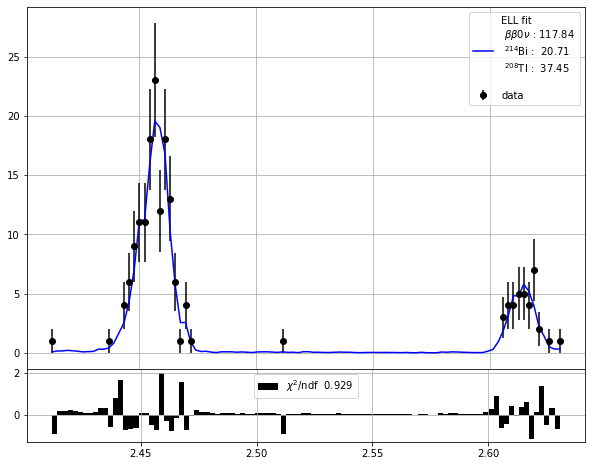

In [11]:
#  do the analysis
res, ene, ell, effs = fn.ana_experiment(mdat, mcs, nevts)
ns_est = res.x 
ns_exp = [ni * eff[0] for ni, eff in zip(nevts, effs)]
names   = ['bb0nu', 'Bi', 'Tl']
print('number estimated events :', *['{:s} \t {:6.2f},'.format(s, ni) for s, ni in zip(samples, ns_est)])
print('number expected  events :', *['{:s} \t {:6.2f},'.format(s, ni) for s, ni in zip(samples, ns_exp)])
fn.plot_fit_ell(ene, ns_est, ell.pdf)
print(np.sum(ns_est), np.sum(ns_exp), len(ene))

### Generate n-experiments in different signal scenarios.

Generate n-experiments (1000) with different 0bbnu events, for example 100, 10, 2 events in the RoI. 

Be careful with the case of very few bb0nu events in the RoI.

Get the distribution of the estimated number of events. 

Estimate the number of events uncertainties for each scenario

In [12]:
def experiments(size, nevts, mcs, ssamples = ssamples, plot = True):
            
    mevts  = []
    ns_exp = []
    for i in range(size):
        mdat             = fn.generate_mc_experiment(mcs, nevts)
        res, _, _, effs  = fn.ana_experiment(mdat, mcs, nevts)
        if (i == 0):
            ns_exp = [ni * eff[0] for ni, eff in zip(nevts, effs)]
            print('expected events ', ns_exp)
        if (res.success == True):
            mevts.append(res.x)
            
    def _plot():
        subplot = pltext.canvas(4)
        for i in range(3):
            subplot(i + 1)
            nn = [m[i] for m in mevts]
            nm = ns_exp[i]
            pltext.hist(nn, 100, label = r'n = {:6.2f}'.format(nm));
            plt.xlabel('number events');
            plt.title(ssamples[i])
        plt.tight_layout()

    if (plot): _plot()
            
    return mevts, ns_exp    

expected events  [100.0, 25.05048, 39.0925]


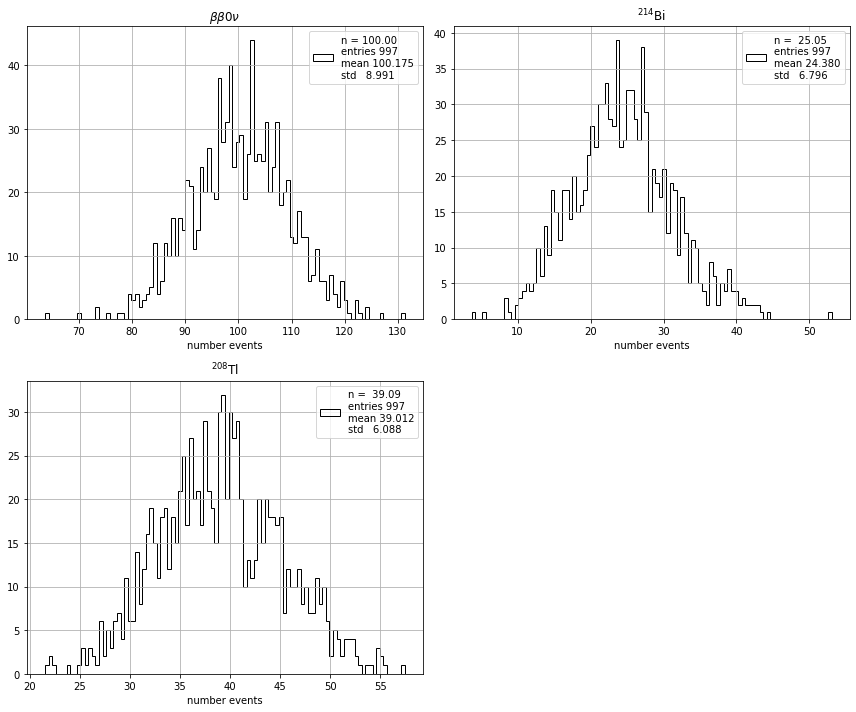

In [13]:
size    = 1000
nbb_roi = 100
nevts = nevents(nbb_roi, nbi, ntl)

mevts, ns_exp = experiments(size, nevts, mcs)

expected events  [10.0, 25.05048, 39.0925]


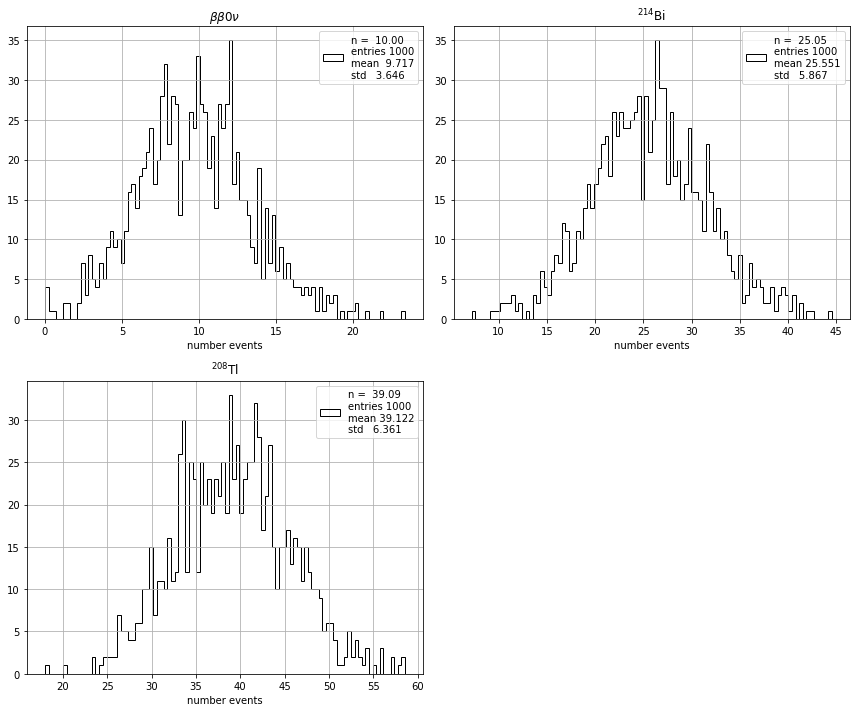

In [14]:
size    = 1000
nbb_roi = 10
nevts = nevents(nbb_roi, nbi, ntl)

mevts, ns_exp = experiments(size, nevts, mcs)

expected events  [2.0, 25.05048, 39.0925]


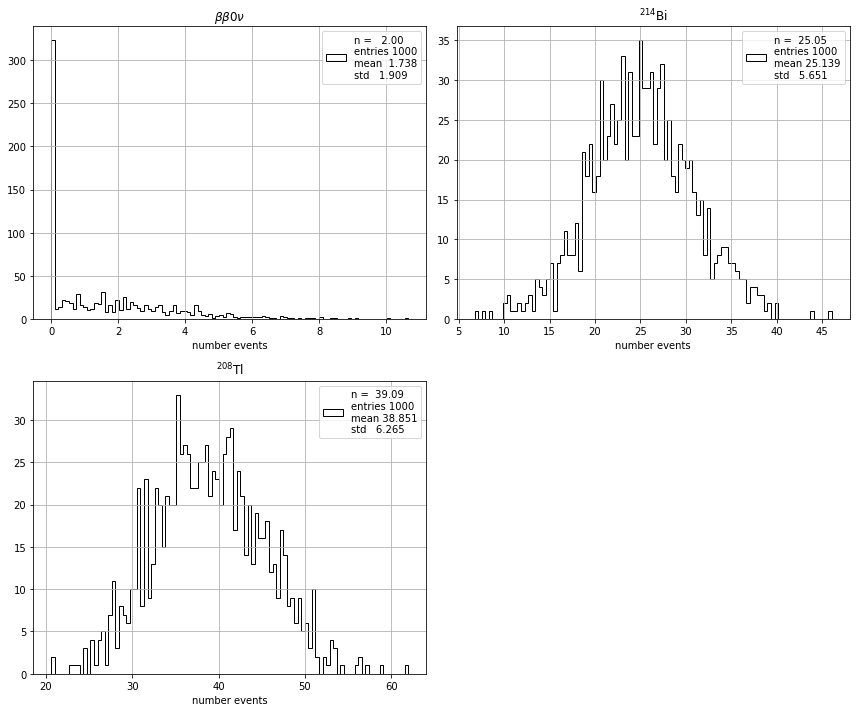

In [15]:
size    = 1000
nbb_roi = 2
nevts = nevents(nbb_roi, nbi, ntl)

mevts, ns_exp = experiments(size, nevts, mcs)

## Estimate the half-time

In [16]:
erange     = (2.400, 2.650)
eroi       = (2.440, 2.475)
keys       = ['E', 'num_tracks', 'blob2_E', 'RoI']
varnames   = ['E', 'num_tracks', 'blob2_E', 'E']
varranges  = [erange, (1., 1.1), (0.4, np.inf), eroi]

exposure   = 500 # kg y
# get the final selection
sel        = ut.selections(mcbb, varnames, varranges)[-1] 
# comptue the efficiency
eff, ueff  = ut.efficiency(sel) 

nbb = 10
tau  = fn.half_life(nbb, exposure, eff)
print('bb0nu half-life {:6.2e} y '.format(tau))

#TODO: uncertainties

bb0nu half-life 5.04e+25 y 
